# Customer Segmentation - Marketing Campaign Analysis

## Author: Rafał Mazur
## Date: 2024-03-28

This notebook contains a comprehensive analysis of customer segmentation based on marketing campaign data. The project uses advanced machine learning techniques to identify and analyze different customer segments, enabling better understanding of purchasing behaviors and development of effective marketing strategies.

## 1. Import Libraries and Configuration

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import datetime as dt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Set plot size
plt.rcParams['figure.figsize'] = [12, 8]

## 2. Load and Prepare Data

In [2]:
# Load data
df = pd.read_csv('marketing_campaign.csv',sep='\t')

print(f'Data loaded. Shape: {df.shape}')

# Prepare data
df_clean = df.copy()

# Calculate customer age
current_year = dt.datetime.now().year
df_clean['Age'] = current_year - df_clean['Year_Birth']

# Calculate total amount spent on products
df_clean['TotalSpent'] = df_clean['MntWines'] + df_clean['MntFruits'] + \
                       df_clean['MntMeatProducts'] + df_clean['MntFishProducts'] + \
                       df_clean['MntSweetProducts'] + df_clean['MntGoldProds']

# Calculate total number of purchases
df_clean['TotalPurchases'] = df_clean['NumDealsPurchases'] + df_clean['NumWebPurchases'] + \
                           df_clean['NumCatalogPurchases'] + df_clean['NumStorePurchases']

# Calculate number of children in household
df_clean['Children'] = df_clean['Kidhome'] + df_clean['Teenhome']

# Clean data - remove missing income values
df_clean = df_clean.dropna(subset=['Income'])

# Convert customer enrollment date
df_clean['Dt_Customer'] = pd.to_datetime(df_clean['Dt_Customer'], format='%d-%m-%Y')

# Calculate days since customer enrollment
df_clean['CustomerDays'] = (pd.Timestamp.now() - df_clean['Dt_Customer']).dt.days

# Calculate campaign acceptance rate
df_clean['AcceptedCmpTotal'] = df_clean['AcceptedCmp1'] + df_clean['AcceptedCmp2'] + \
                             df_clean['AcceptedCmp3'] + df_clean['AcceptedCmp4'] + \
                             df_clean['AcceptedCmp5']

# Remove outliers - age above 100
df_clean = df_clean[df_clean['Age'] < 100]

print('\nPrepared data:')
print(df_clean.head())

Data loaded. Shape: (2240, 29)

Prepared data:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  Complain  Z_CostContact  Z_Revenue  \
0  2012-09-04       58       635  ...         0              3         11   
1  2014-03-08       38        11  ...         0              3         11   
2  2013-08-21       26       426  ...         0              3         11   
3  2014-02-10       26        11  ...         0              3         11   
4  2014-01-19       94       173  ...         0              3         11   

   Response  Age  Tot

## 3. Exploratory Data Analysis (EDA)

In [3]:
# Basic information about data
print("Data Information:")
print(df_clean.info())

print("\nDescriptive Statistics:")
print(df_clean.describe())

print("\nChecking for Missing Values:")
print(df_clean.isnull().sum())

Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 2213 entries, 0 to 2239
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2213 non-null   int64         
 1   Year_Birth           2213 non-null   int64         
 2   Education            2213 non-null   object        
 3   Marital_Status       2213 non-null   object        
 4   Income               2213 non-null   float64       
 5   Kidhome              2213 non-null   int64         
 6   Teenhome             2213 non-null   int64         
 7   Dt_Customer          2213 non-null   datetime64[ns]
 8   Recency              2213 non-null   int64         
 9   MntWines             2213 non-null   int64         
 10  MntFruits            2213 non-null   int64         
 11  MntMeatProducts      2213 non-null   int64         
 12  MntFishProducts      2213 non-null   int64         
 13  MntSweetProducts    

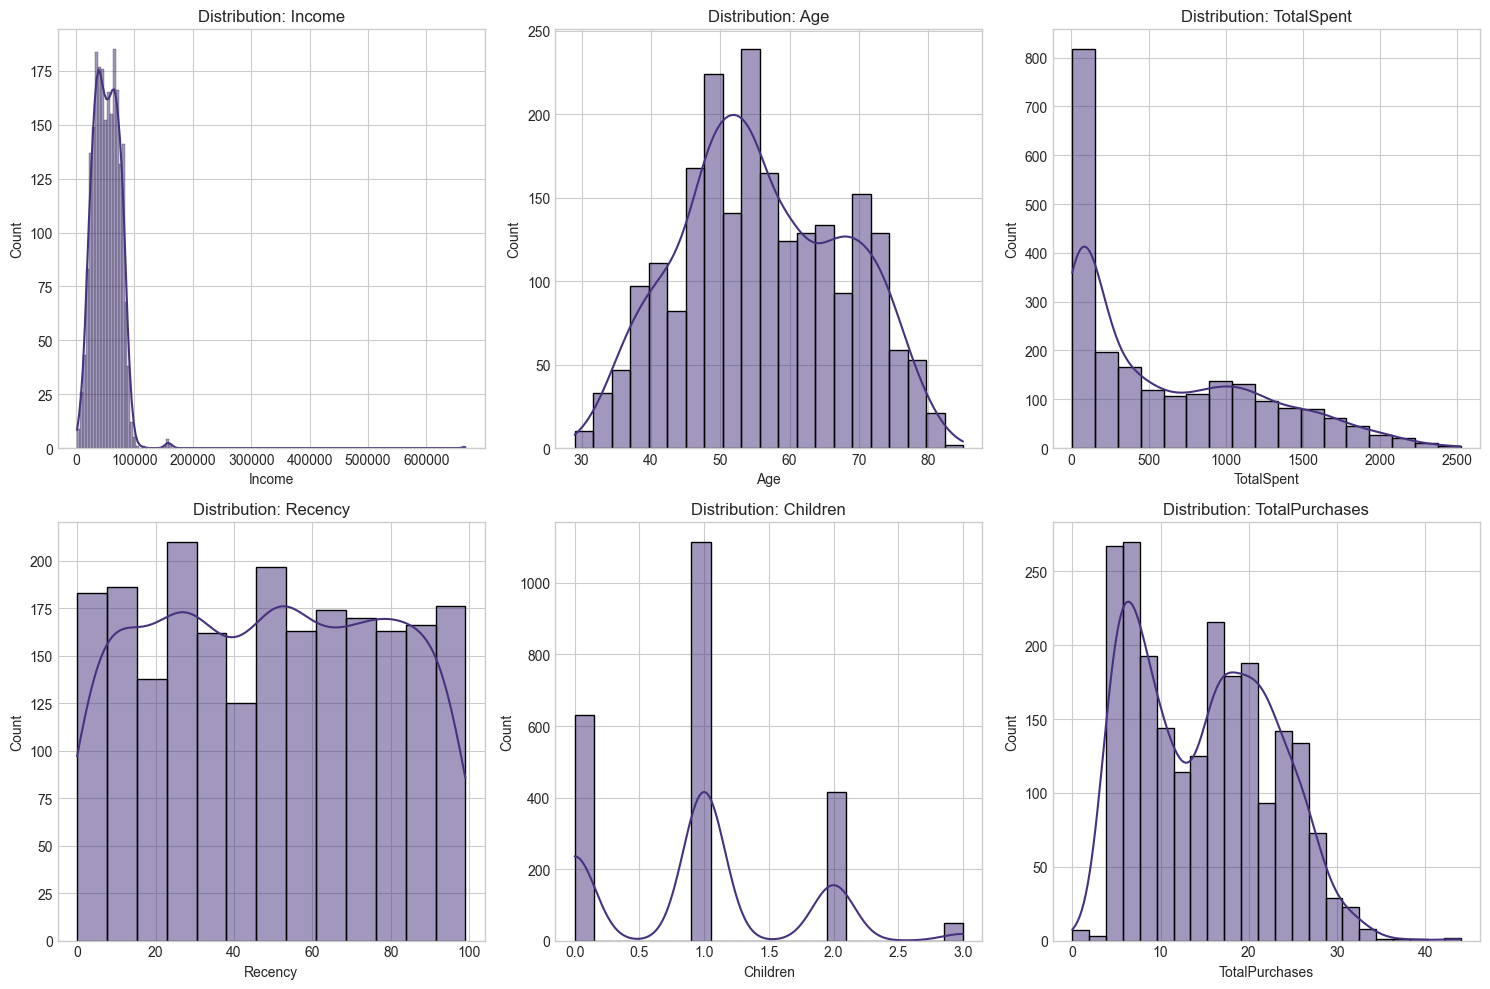

In [4]:
# Histograms for numerical variables
plt.figure(figsize=(15, 10))
for i, col in enumerate(['Income', 'Age', 'TotalSpent', 'Recency', 'Children', 'TotalPurchases']):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_clean[col], kde=True)
    plt.title(f'Distribution: {col}')
plt.tight_layout()
plt.show()

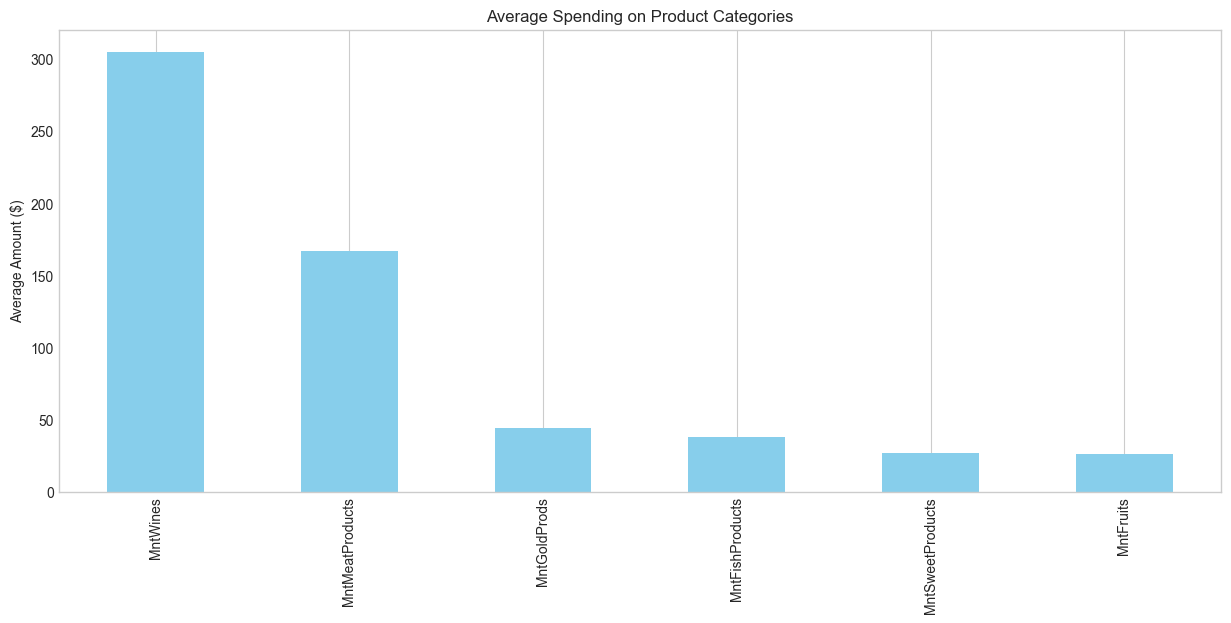

In [5]:
# Distribution of spending on product categories
product_categories = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
plt.figure(figsize=(15, 6))
df_clean[product_categories].mean().sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Average Spending on Product Categories')
plt.ylabel('Average Amount ($)')
plt.grid(axis='y')
plt.show()

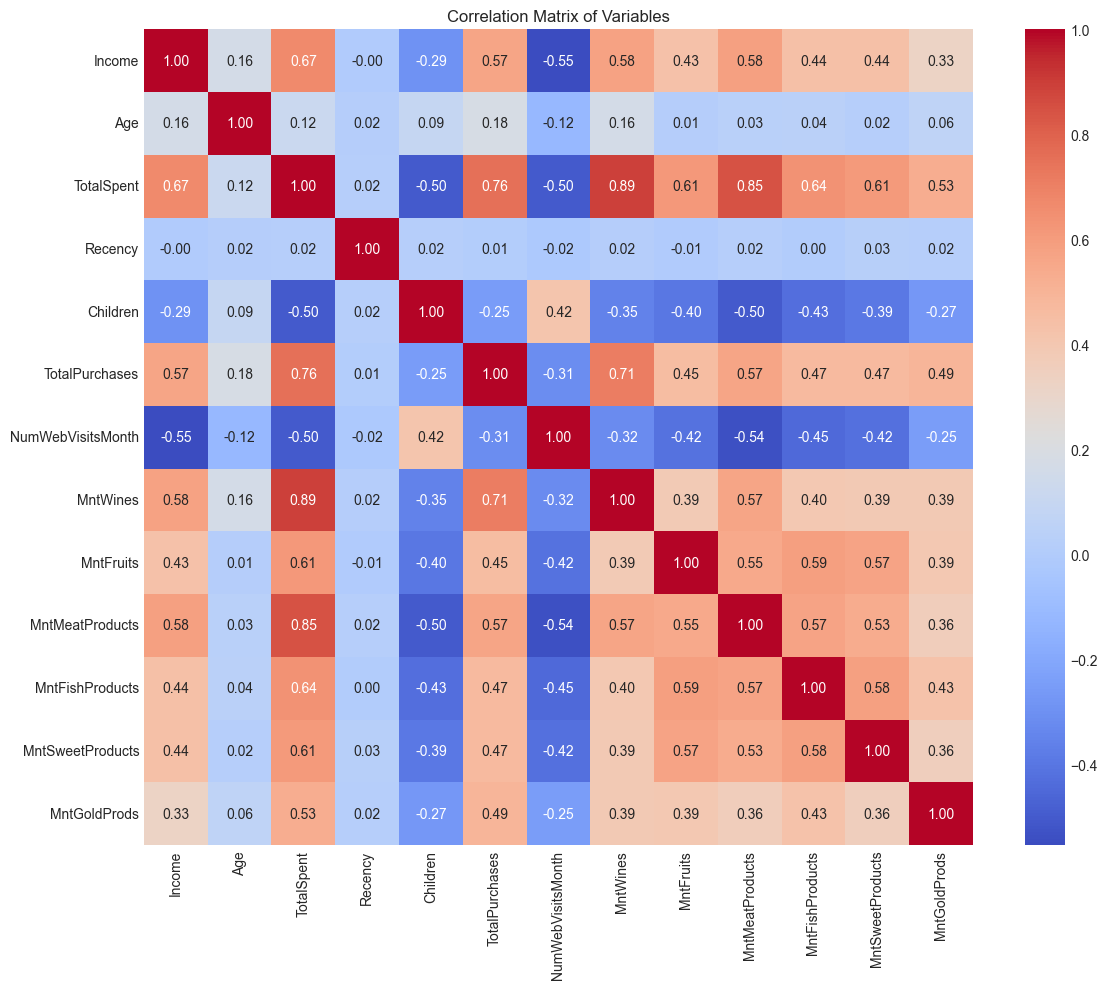

In [6]:
# Correlation plot
plt.figure(figsize=(12, 10))
numeric_cols = ['Income', 'Age', 'TotalSpent', 'Recency', 'Children', 'TotalPurchases', 
                'NumWebVisitsMonth'] + product_categories
correlation_matrix = df_clean[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Variables')
plt.tight_layout()
plt.show()

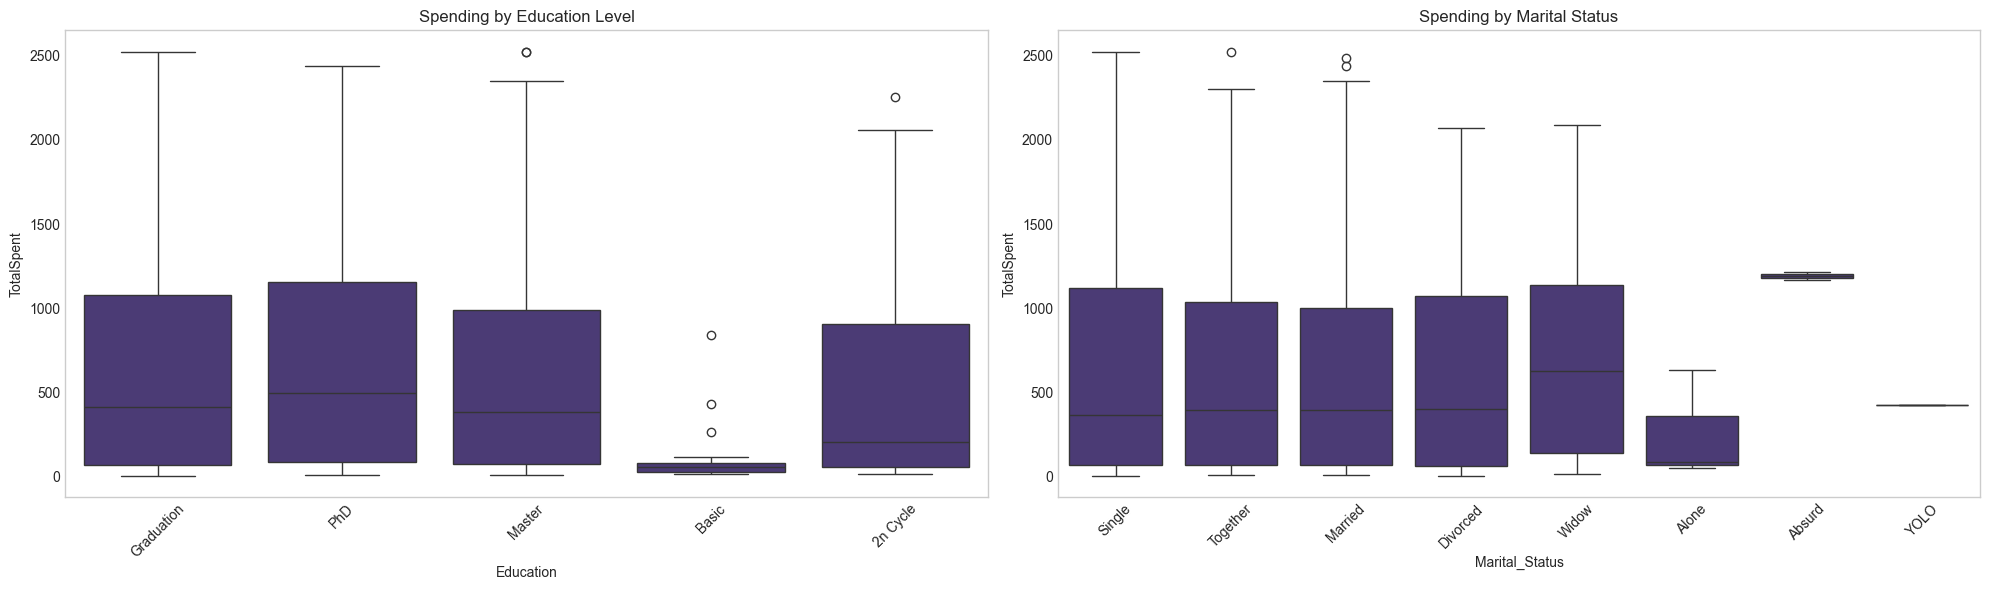

In [7]:
# Spending by education and marital status
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.boxplot(x='Education', y='TotalSpent', data=df_clean, ax=ax1)
ax1.set_title('Spending by Education Level')
ax1.grid(axis='y')
ax1.tick_params(axis='x', rotation=45)

sns.boxplot(x='Marital_Status', y='TotalSpent', data=df_clean, ax=ax2)
ax2.set_title('Spending by Marital Status')
ax2.grid(axis='y')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Prepare Data for Segmentation

In [8]:
# Select columns for clustering
cluster_cols = ['Income', 'Age', 'TotalSpent', 'Recency', 'TotalPurchases', 'NumWebVisitsMonth']

# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean[cluster_cols])

print('Shape of data after standardization:', df_scaled.shape)

Shape of data after standardization: (2213, 6)


## 5. Determine Optimal Number of Clusters

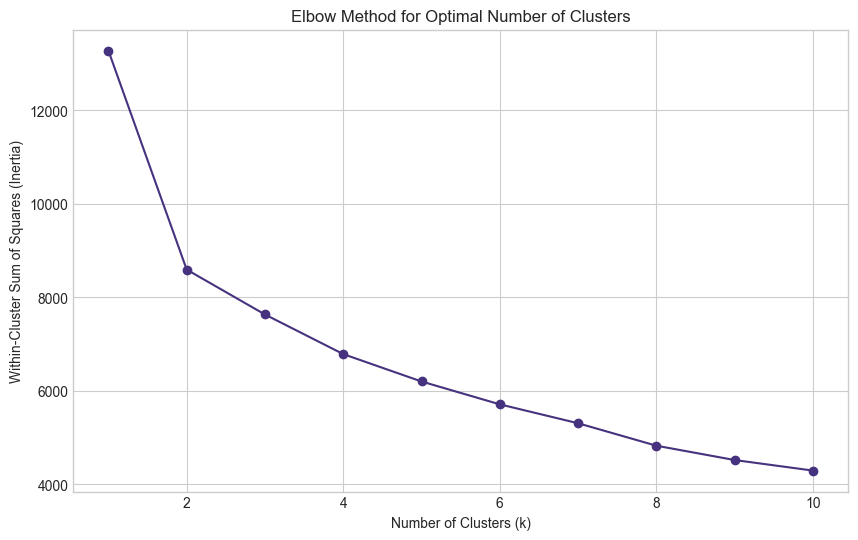


Selected number of clusters: 4


In [9]:
# Elbow method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Elbow method plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

# Select optimal number of clusters
optimal_k = 4
print(f"\nSelected number of clusters: {optimal_k}")

## 6. Customer Segmentation

In [10]:
# Apply K-means algorithm
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_scaled)

# Add cluster information to original DataFrame
df_clean['Cluster'] = clusters

# Analyze cluster centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                        columns=cluster_cols)
centroids.index.name = 'cluster'

print("Cluster Centroids (mean values for each segment):")
print(centroids)

print("\nNumber of customers in each segment:")
print(df_clean['Cluster'].value_counts().sort_index())

Cluster Centroids (mean values for each segment):
               Income        Age   TotalSpent    Recency  TotalPurchases  \
cluster                                                                    
0        36491.351449  54.469203   135.221014  75.568841        9.027174   
1        78885.130435  54.852552  1347.243856  51.158790       20.047259   
2        34986.005085  52.477966   126.996610  24.093220        8.703390   
3        61041.239852  62.850554   887.595941  46.977860       22.560886   

         NumWebVisitsMonth  
cluster                     
0                 6.409420  
1                 2.366730  
2                 6.518644  
3                 5.795203  

Number of customers in each segment:
Cluster
0    552
1    531
2    590
3    540
Name: count, dtype: int64


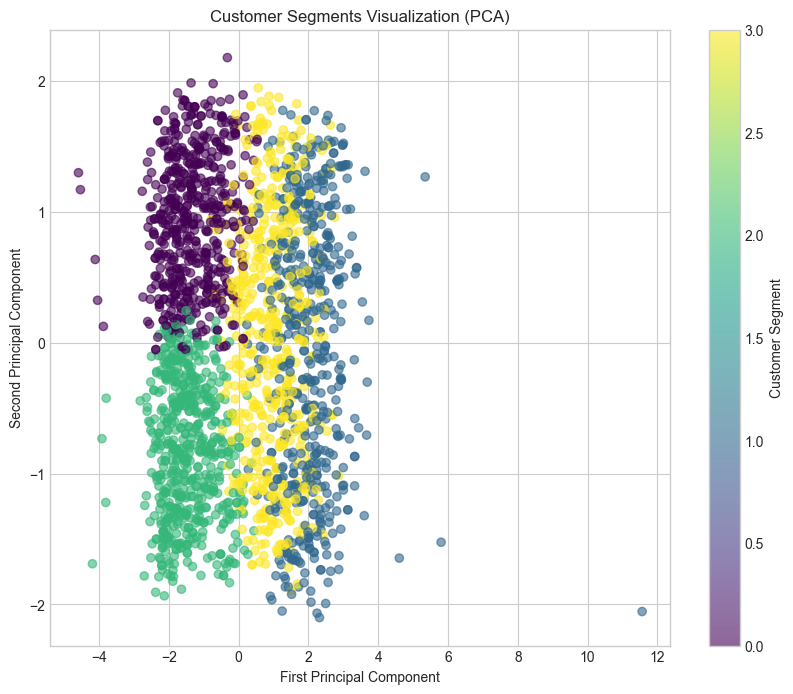

In [11]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Customer Segment')
plt.title('Customer Segments Visualization (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

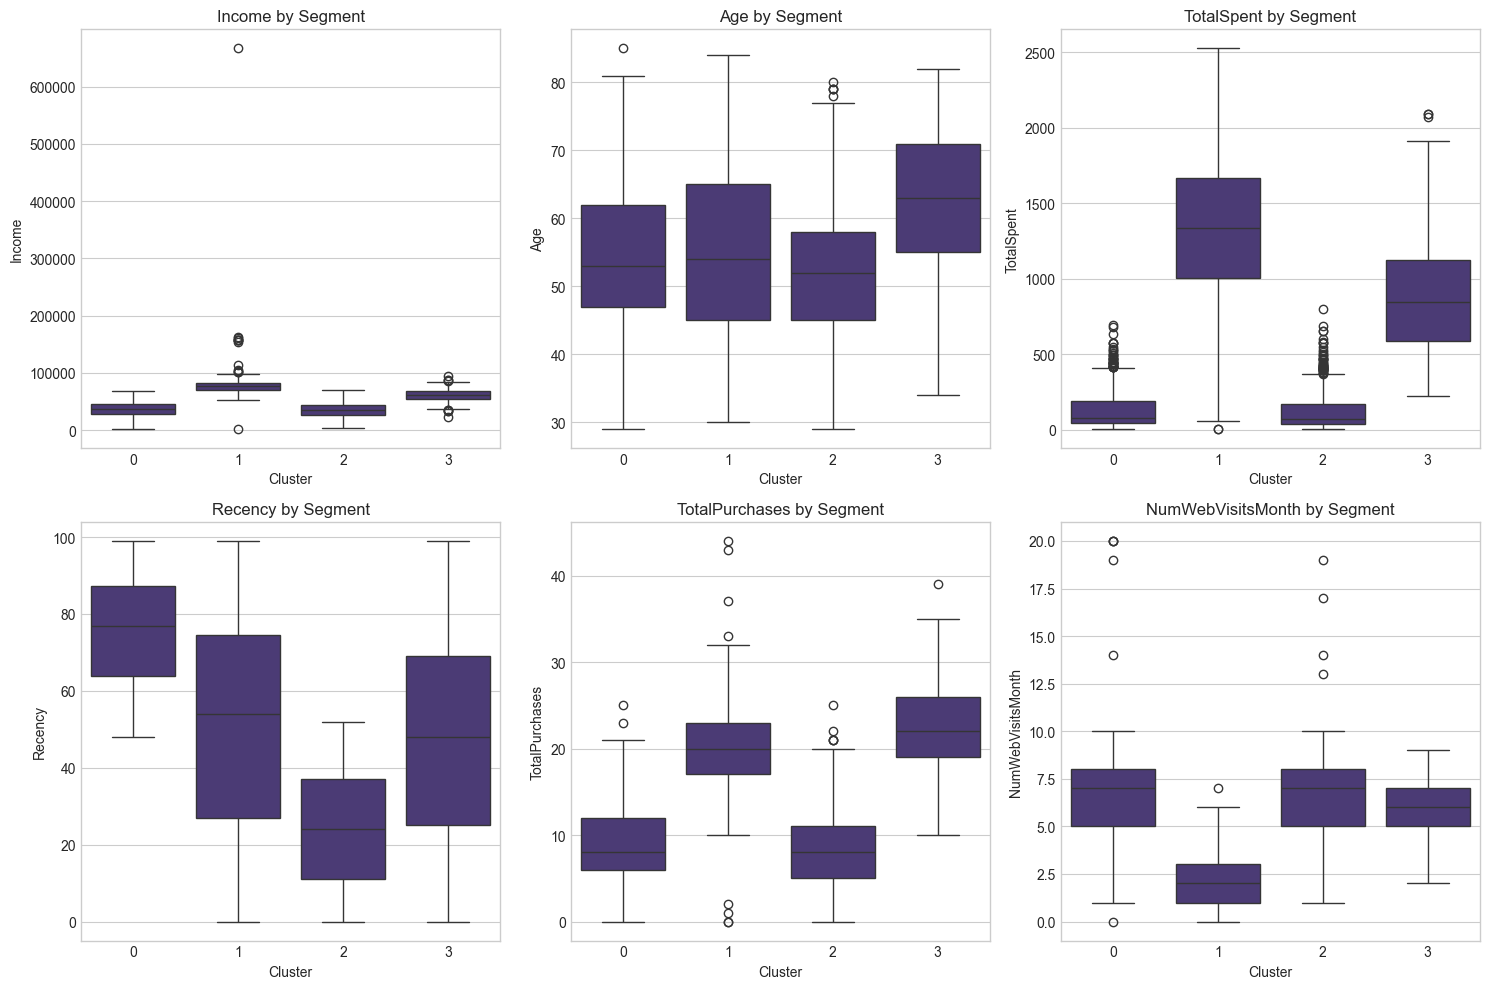

In [12]:
# Visualize features for each cluster
plt.figure(figsize=(15, 10))
for i, col in enumerate(cluster_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Cluster', y=col, data=df_clean)
    plt.title(f'{col} by Segment')
plt.tight_layout()
plt.show()

## 7. Analyze Product Category Spending by Segments

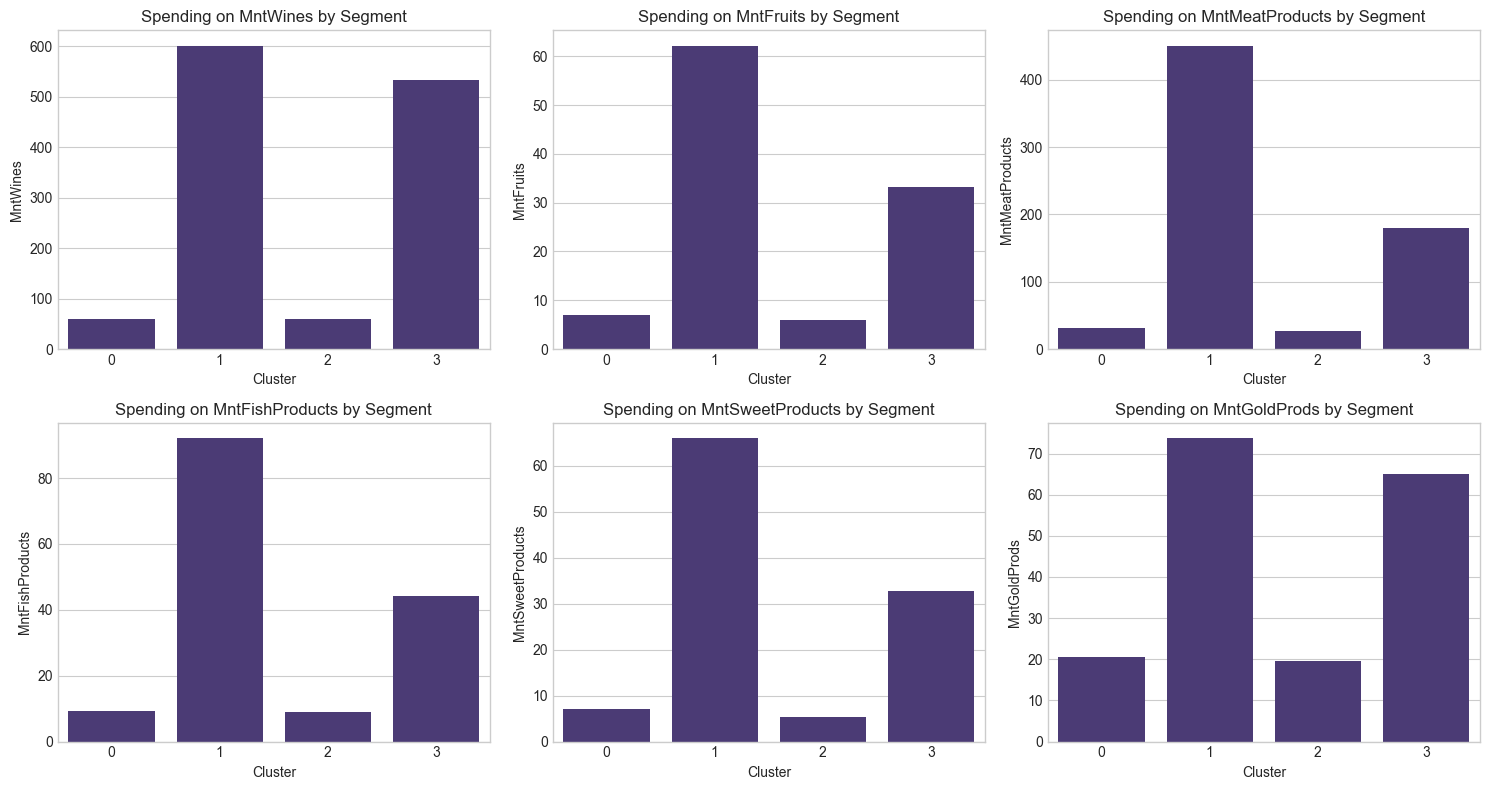

In [13]:
# Analyze spending on product categories by segments
plt.figure(figsize=(15, 8))
for i, category in enumerate(product_categories):
    plt.subplot(2, 3, i+1)
    sns.barplot(x='Cluster', y=category, data=df_clean, ci=None)
    plt.title(f'Spending on {category} by Segment')
plt.tight_layout()
plt.show()

## 8. Analyze Campaign Acceptance by Segments

<Figure size 1200x600 with 0 Axes>

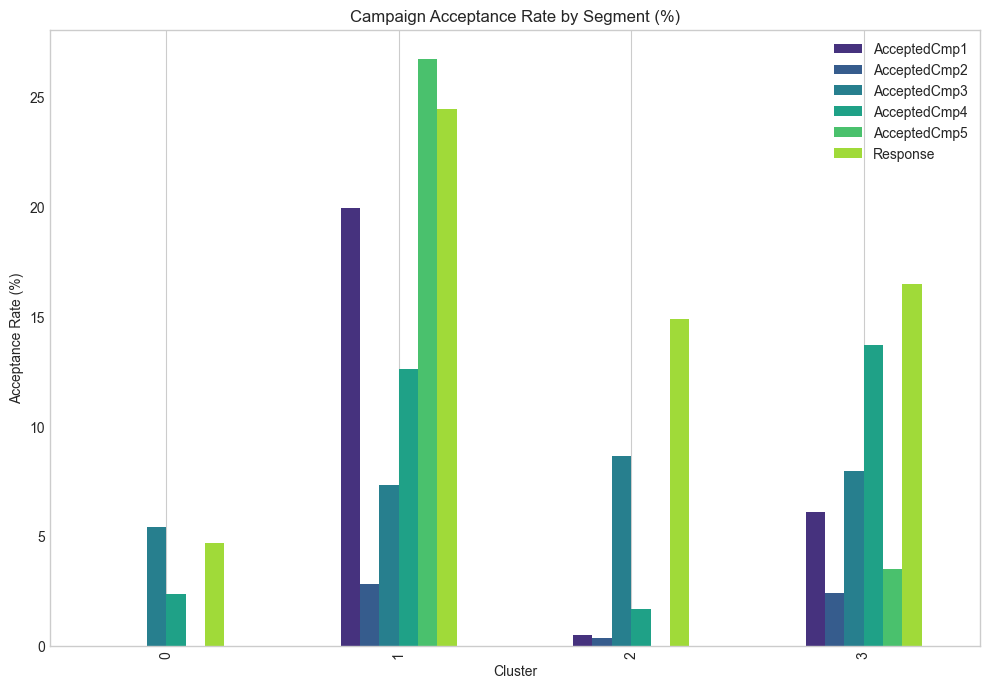

In [14]:
# Analyze campaign acceptance frequency by segments
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
campaign_acceptance = df_clean.groupby('Cluster')[campaign_cols].mean() * 100

plt.figure(figsize=(12, 6))
campaign_acceptance.plot(kind='bar')
plt.title('Campaign Acceptance Rate by Segment (%)')
plt.ylabel('Acceptance Rate (%)')
plt.grid(axis='y')
plt.show()

## 9. Analyze and Interpret Segments

<Figure size 1200x800 with 0 Axes>

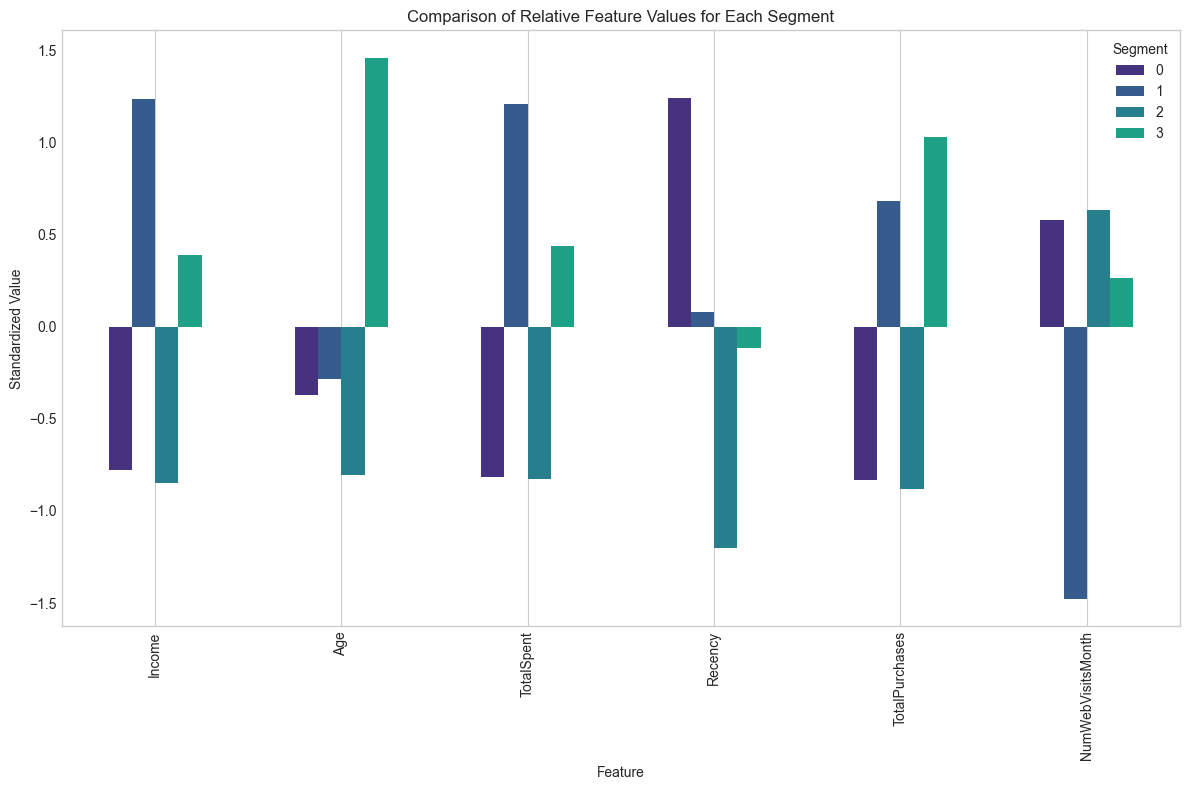

In [15]:
# Standardize centroids for relative value comparison
centroids_std = centroids.copy()
for col in cluster_cols:
    centroids_std[col] = (centroids[col] - centroids[col].mean()) / centroids[col].std()

# Visualize normalized centroids
plt.figure(figsize=(12, 8))
centroids_std.T.plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of Relative Feature Values for Each Segment')
plt.ylabel('Standardized Value')
plt.xlabel('Feature')
plt.legend(title='Segment')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

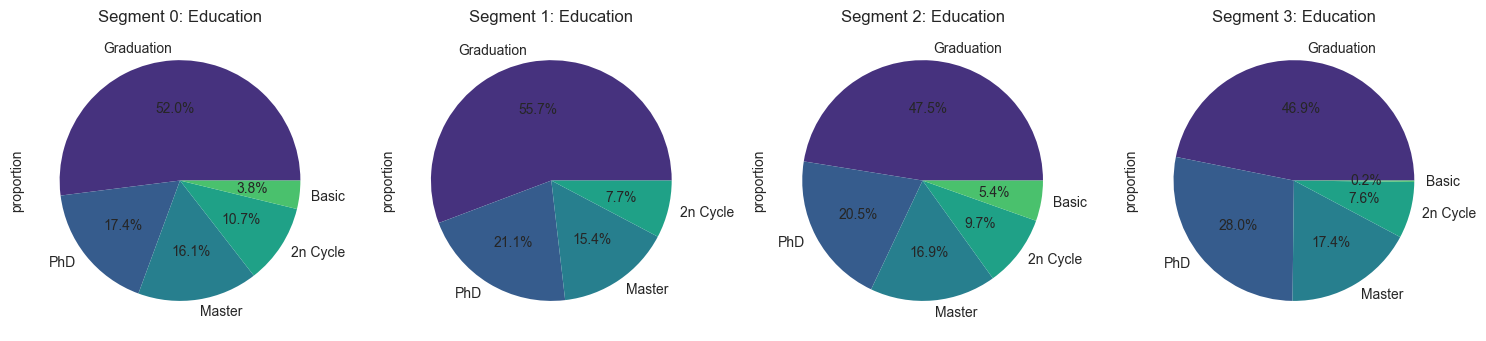

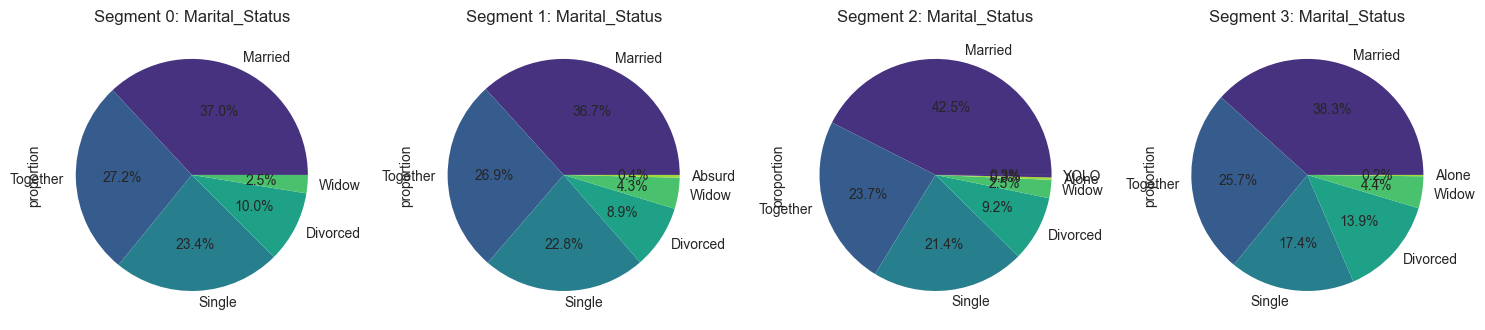

In [16]:
# Analyze distribution of categories for each segment
categorical_cols = ['Education', 'Marital_Status']

for col in categorical_cols:
    plt.figure(figsize=(15, 6))
    for i in range(len(centroids)):
        plt.subplot(1, len(centroids), i+1)
        segment_data = df_clean[df_clean['Cluster'] == i]
        segment_data[col].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
        plt.title(f'Segment {i}: {col}')
    plt.tight_layout()
    plt.show()

## 10. Segment Interpretation and Business Recommendations

### Segment Descriptions:

1. **Segment 0**: Less affluent, older customers with low spending and long inactivity
2. **Segment 1**: Affluent, older customers with high spending but inactive for a long time
3. **Segment 2**: Less affluent, younger customers with low spending but recently active
4. **Segment 3**: Affluent, active customers with high spending and recent purchases

### Business Recommendations:

#### Segment 0 (Inactive Low-Potential Customers):
1. Reactivation program - special offers with large discounts
2. Satisfaction survey - contact to identify issues
3. Promote affordable products matching their historical purchases
4. Promotions on wines, which constitute the largest part of their spending
5. Educational campaigns about product value

#### Segment 1 (Premium Inactive):
1. VIP reactivation program with exclusive offers
2. Promote new premium products in wine and meat categories
3. Exclusive invitations to tastings and events
4. Loyalty programs with rewards for returning to purchases
5. Personalized recommendations based on previous purchases

#### Segment 2 (Active Low-Budget Customers):
1. Cart building program - incentives to increase purchase value
2. Cross-promotions - complementary product suggestions
3. Loyalty program with rewards for purchase regularity
4. Special offers on premium products
5. Educational campaigns about benefits of purchasing higher-end products

#### Segment 3 (Premium Active - Most Valuable Customers):
1. VIP program with dedicated service and special privileges
2. Exclusive access to new products before official launch
3. Personalized premium product recommendations
4. Referral program - rewards for referring friends
5. Retention strategy through regular contact and special events